## Dataset loading

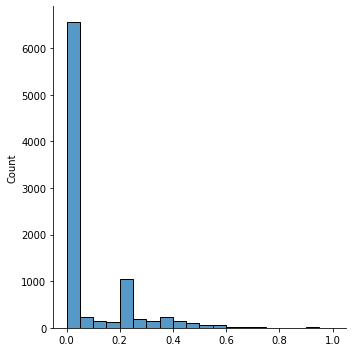

In [59]:
import seaborn as sns
import numpy as np

SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60

input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"

x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
tss_train = np.load(input_path+'tss_train.npz')['arr_0']
tss_test = np.load(input_path+'tss_test.npz')['arr_0']
tss_val = np.load(input_path+'tss_val.npz')['arr_0']

#sns.displot(model.predict(np.concatenate((x_train,x_val, x_test), axis=0)).flatten(), bins=20)
sns.displot(tss_train[tss_train<1], bins=20)

## Plotting whole vital

1/2699(47)...

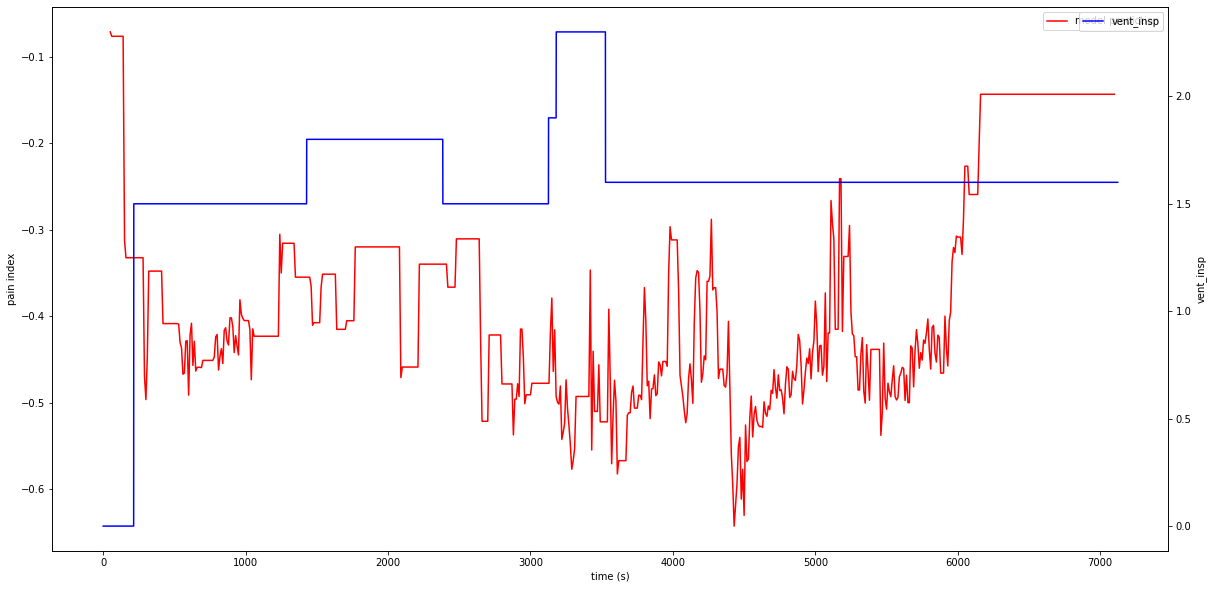

-0.07107227295637131
2/2699(48)...

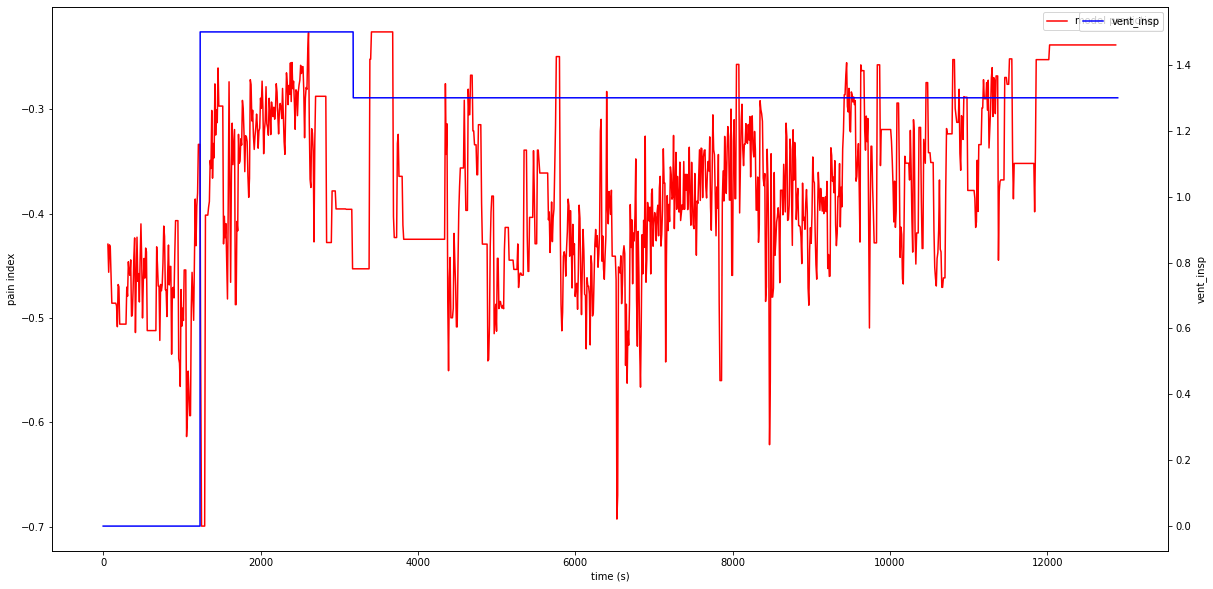

-0.2260362058877945
3/2699(50)...

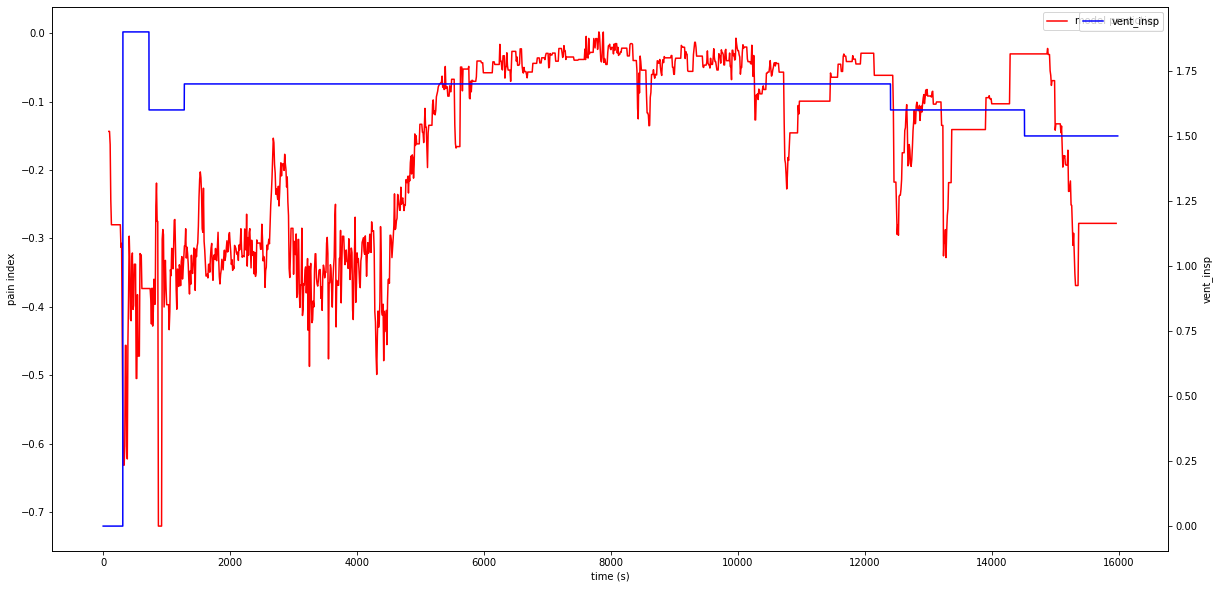

0.0021220576018095016
4/2699(54)...

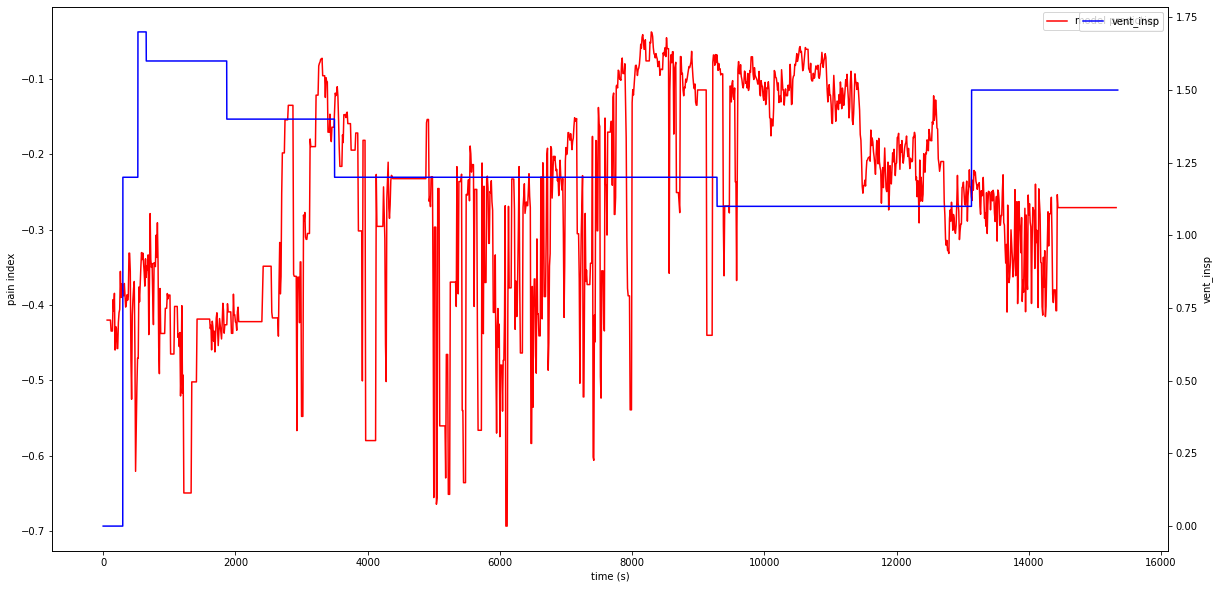

-0.03728996962308884
5/2699(57)...

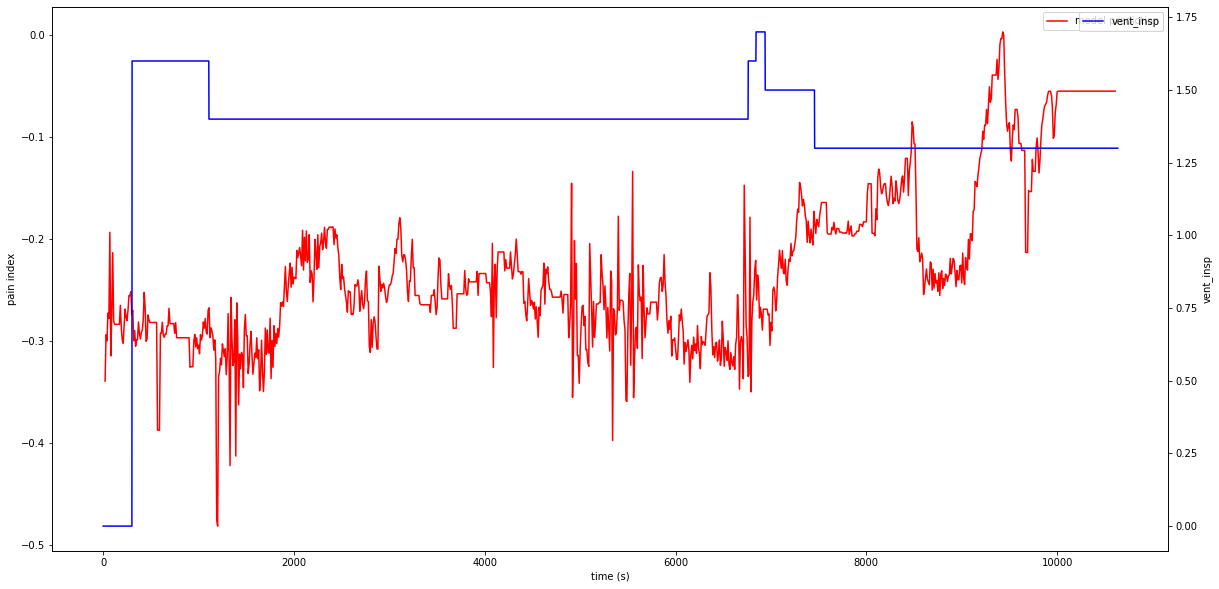

0.0034242291003465652
6/2699(59)...

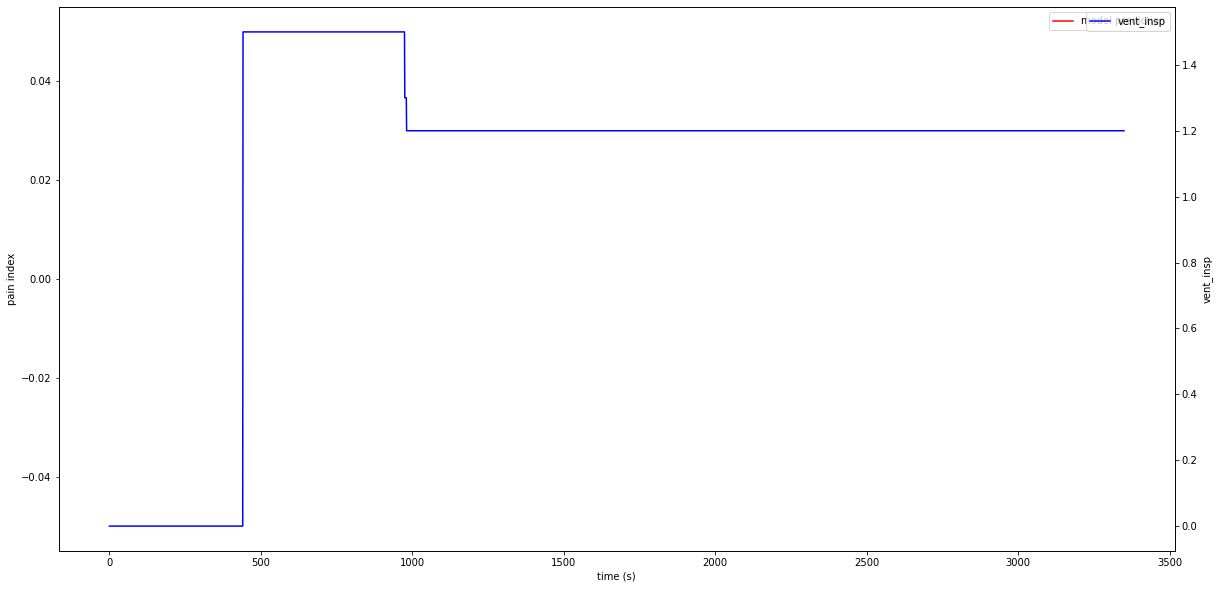

/tmp/ipykernel_1059119/320729138.py:101: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(y_predict))


nan
7/2699(67)...

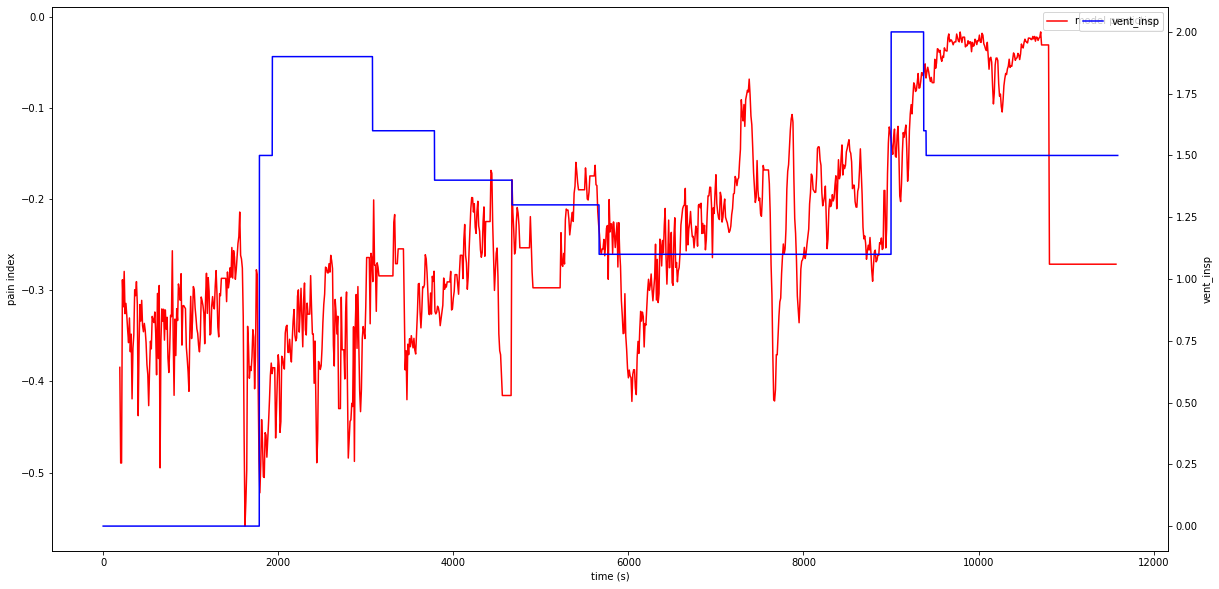

-0.01669282652437687
8/2699(69)...

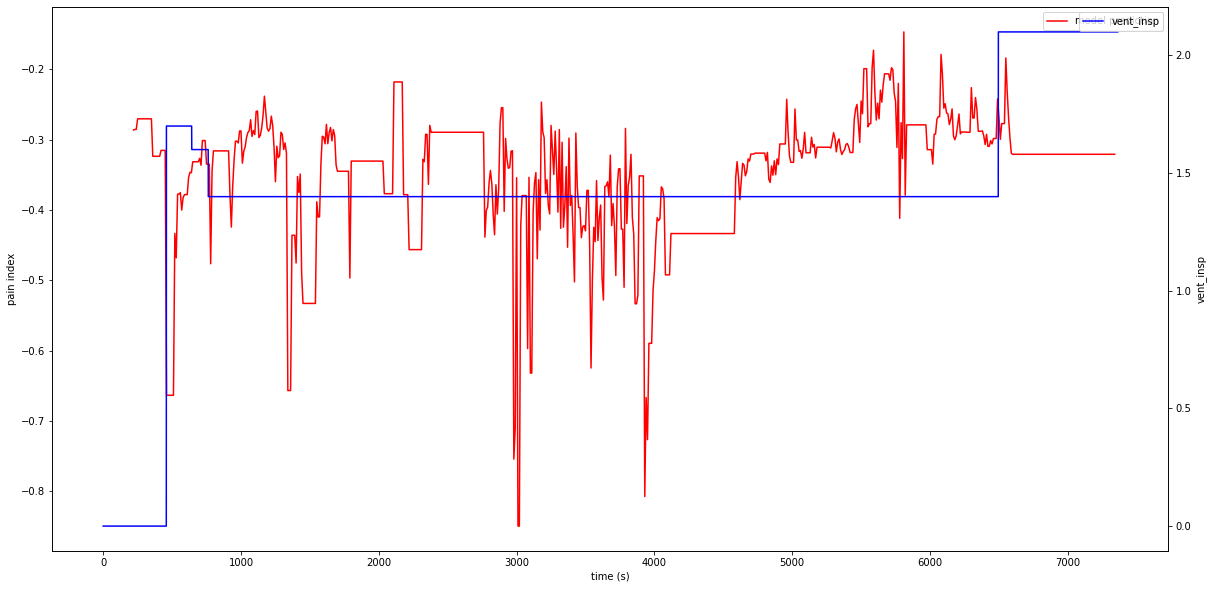

-0.1469329595565796
9/2699(70)...

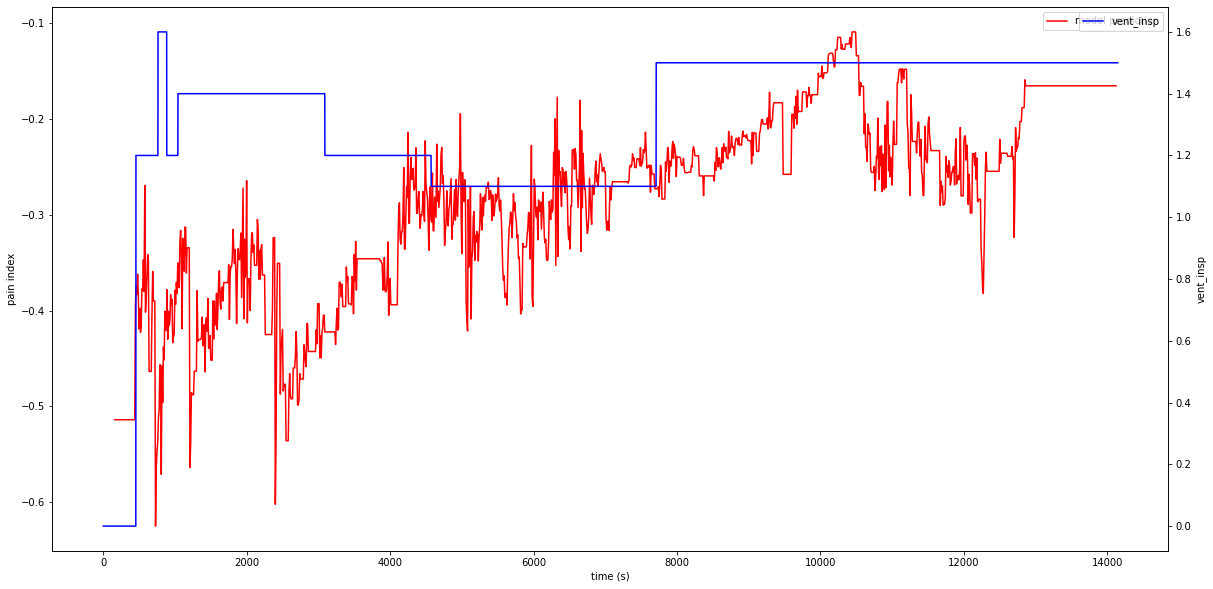

-0.10897369682788849
10/2699(72)...

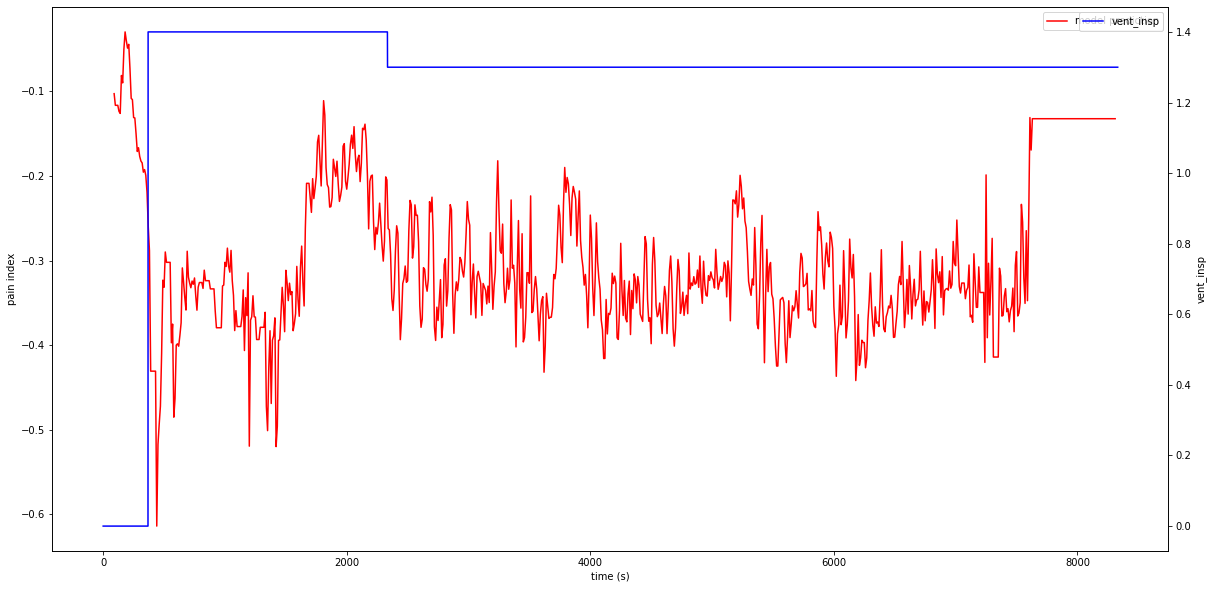

-0.029642289504408836
11/2699(74)...

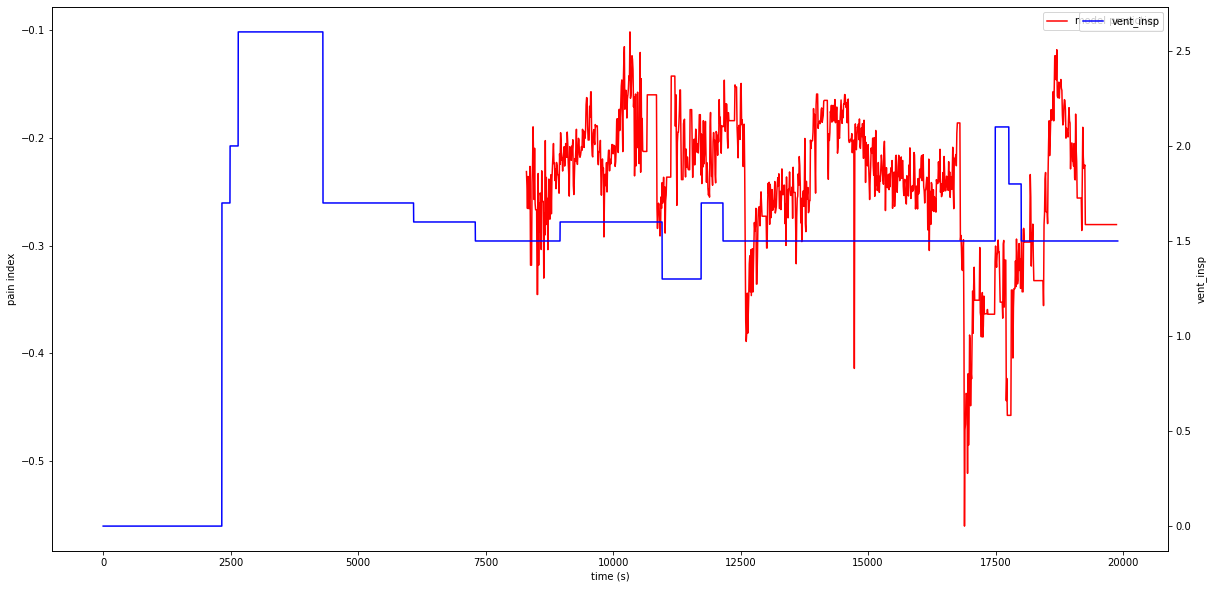

-0.10160955041646957
12/2699(75)...

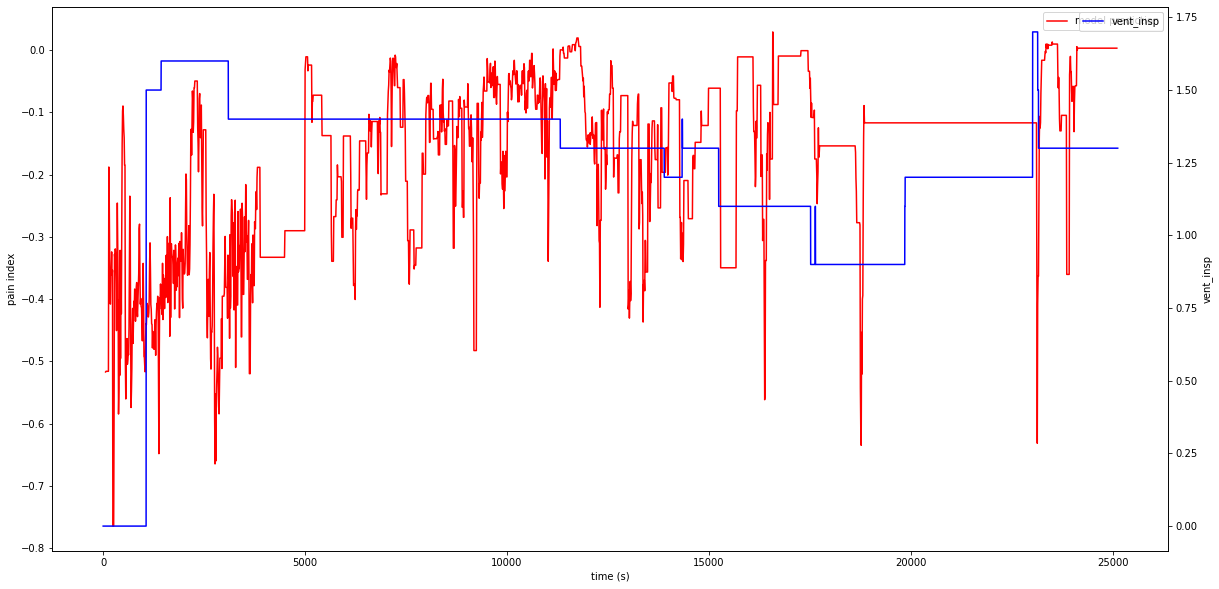

0.02932019717991352
13/2699(77)...

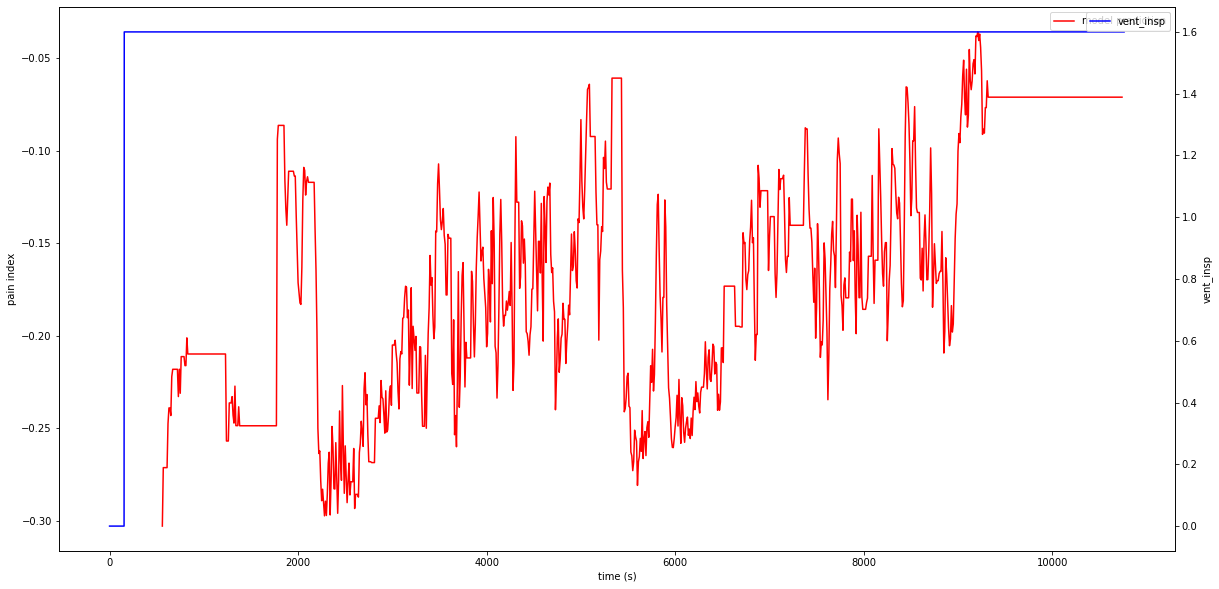

-0.03581041097640991
14/2699(78)...

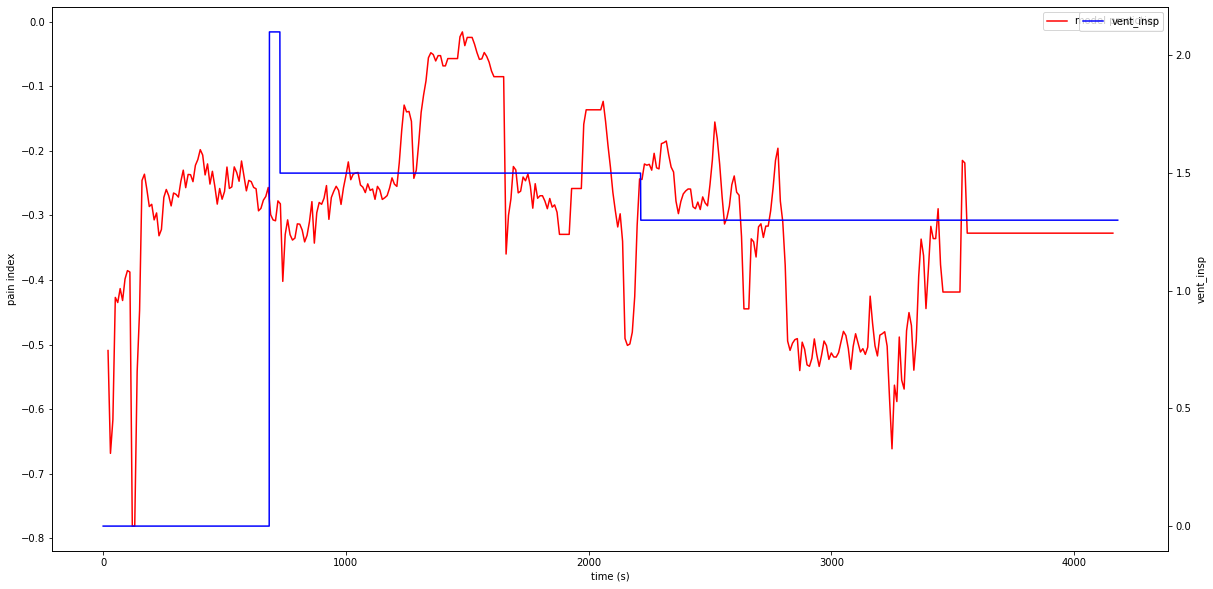

-0.015799636021256447
15/2699(83)...

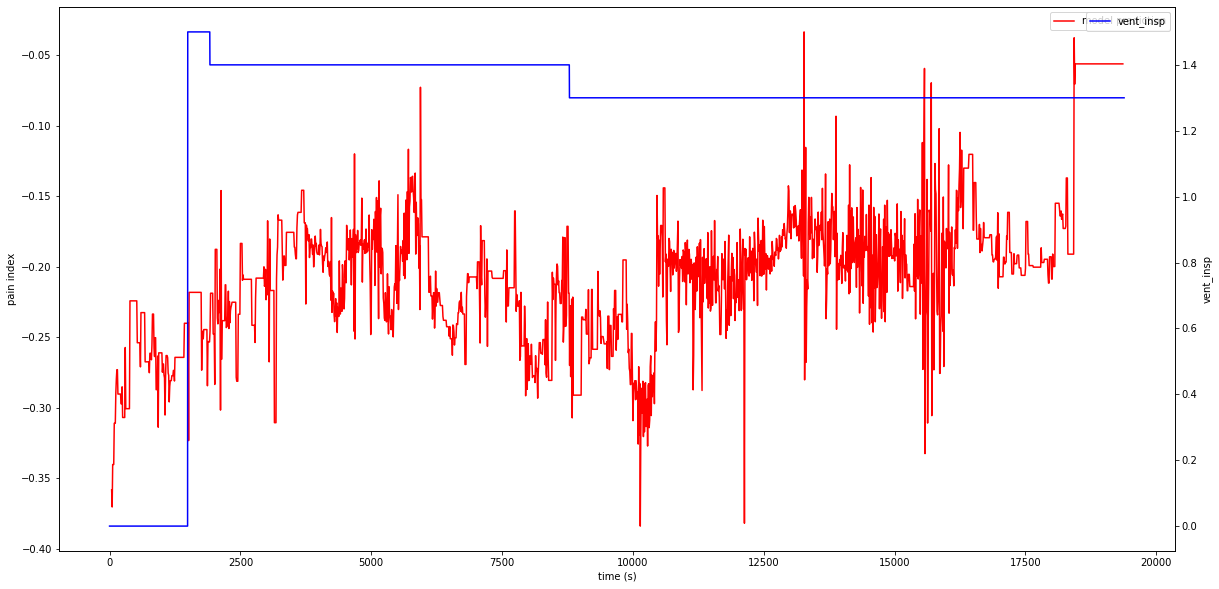

-0.033281780779361725
16/2699(88)...

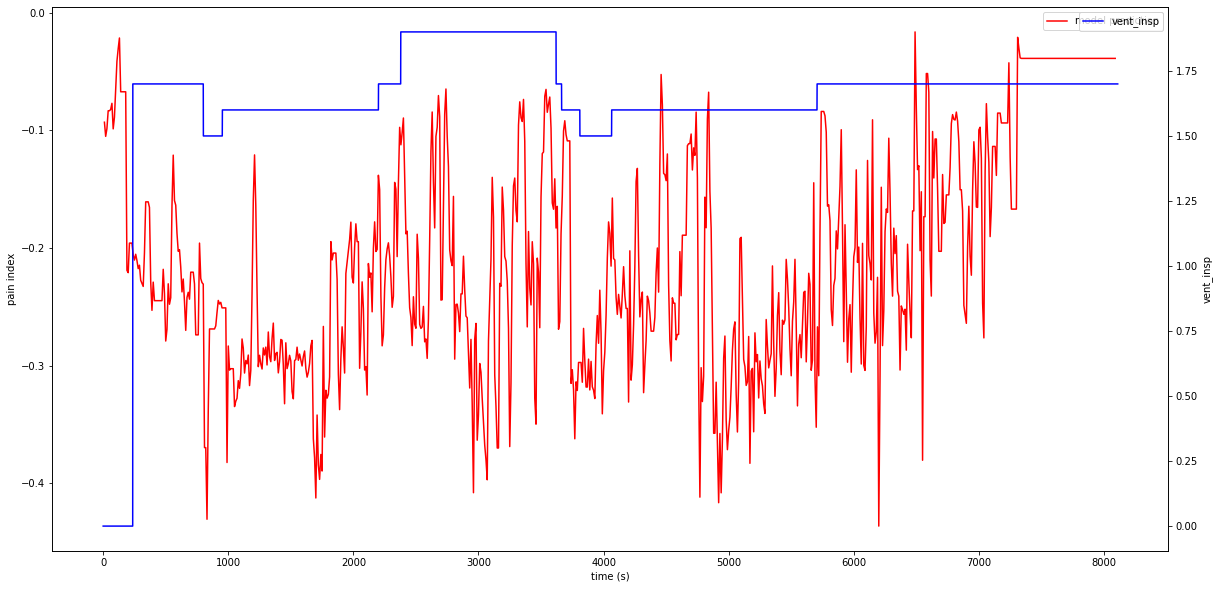

-0.01633676327764988
17/2699(93)...

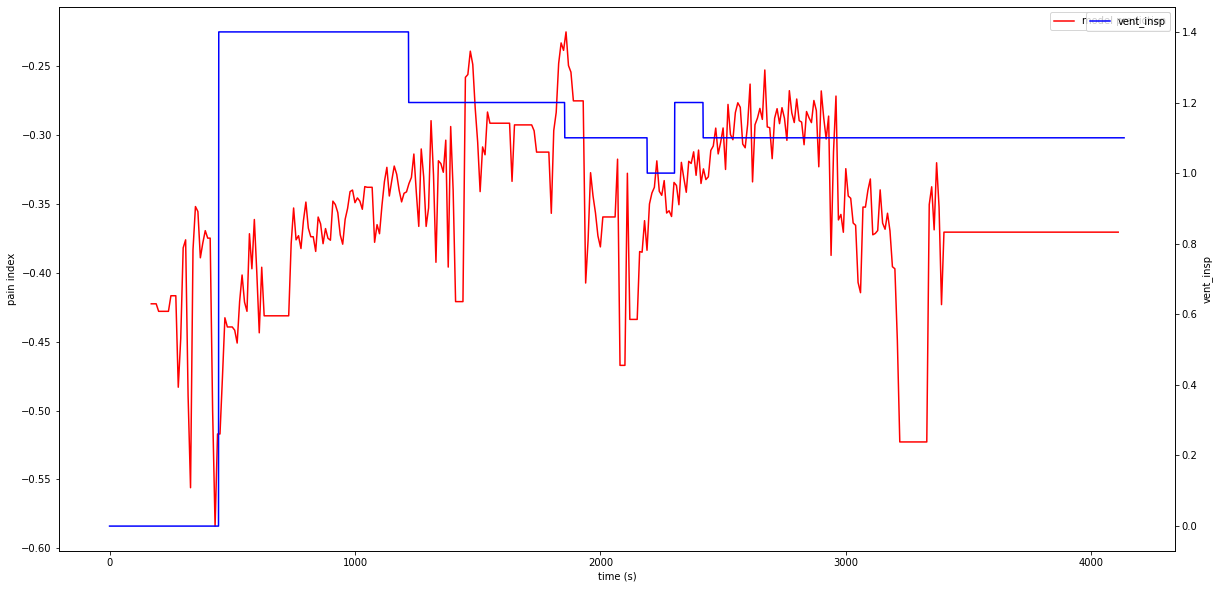

-0.22498728334903717
18/2699(101)...

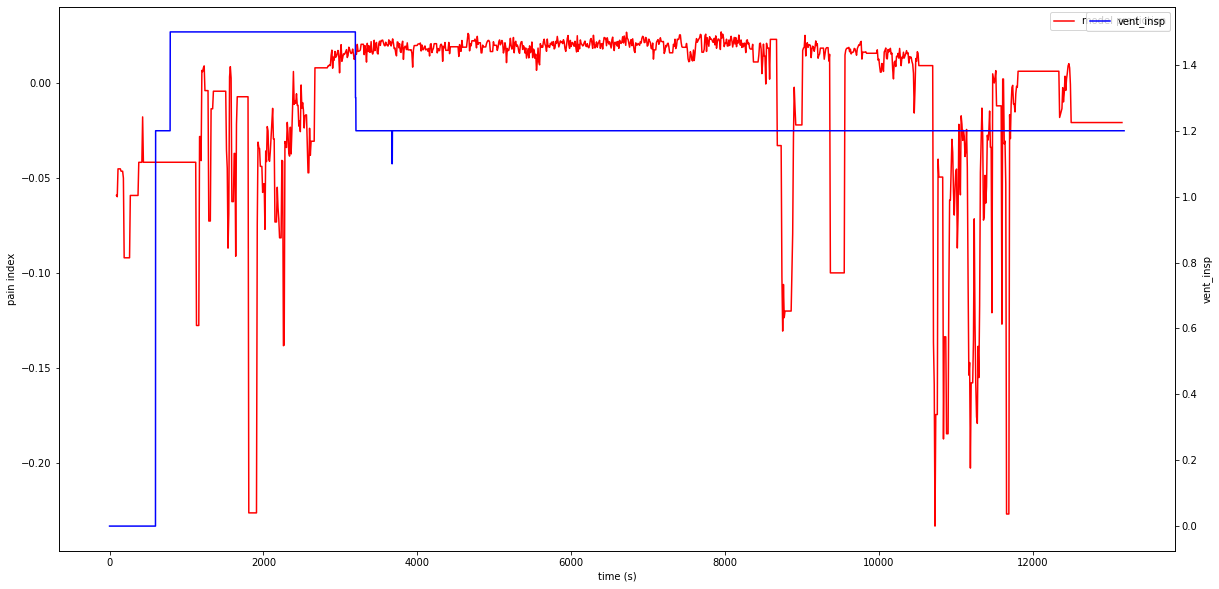

0.02706553228199482
19/2699(103)...

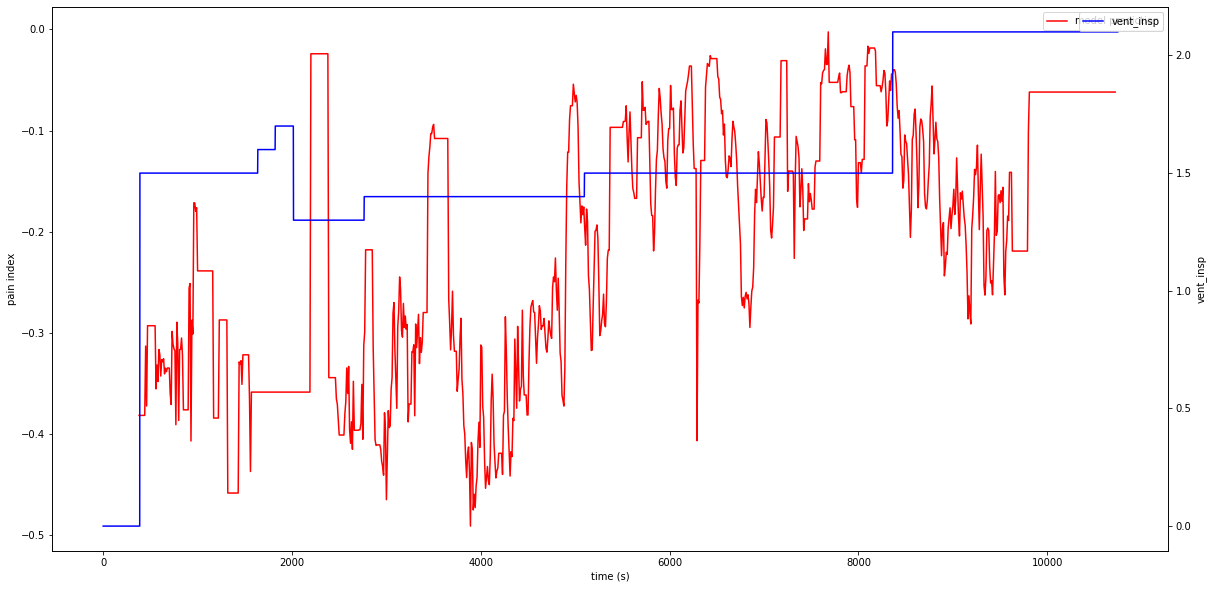

-0.0025076624006032944
20/2699(104)...

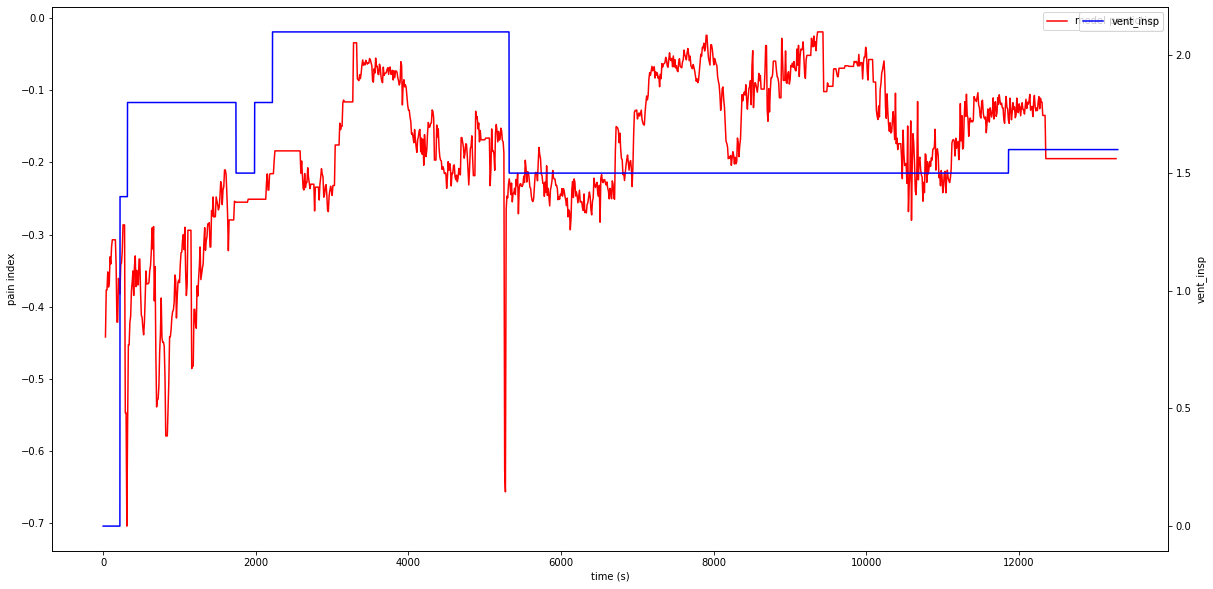

-0.019262144342064857


In [31]:
# loading model
from keras.models import model_from_json
import os, sys
import tensorflow as tf
import statsmodels.api as sm
import numpy as np
import pandas as pd

sys.path.append('../Preprocess/pyvital2/')
import itertools as it
import pandas as pd
import numpy as np
import random
import vitaldb
import arr
import pickle
import matplotlib.pyplot as plt
import scipy.stats


def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T

def linear_connection(list, idx):
    '''
        피크 사이 wave를 모두 같은 length로 만들기 위한 함수
    '''
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)

SRATE = 100
LEN_INPUT = 20
OVERLAP = 10

# create saving folder
file_path = "../Preprocess/cache/peaks/full_vital"
if not os.path.exists(file_path):
    os.mkdir(file_path)

# dataframe of patient information    
df = pd.read_csv("https://api.vitaldb.net/cases")

# target patients' caseids
caseids = list(vitaldb.caseids_tiva & set(df.loc[df['ane_type'] == 'General', 'caseid']))

# tracks to extract / VENT_SET_TV -> VENT_INSP_TM, SET_INSP_TM
track_names = ["SNUADC/ECG_II", "SNUADC/PLETH", "Solar8000/VENT_INSP_TM", "Primus/SET_INSP_TM", "Orchestra/PPF20_CE", "Orchestra/RFTN20_CE"] #, "Solar8000/NIBP_MBP", "Solar8000/ART_MBP", "Solar8000/HR"]


cnt = 0
for caseid in caseids[20:40]:
    cnt = cnt + 1
    print(f'{cnt}/{len(caseids)}({caseid})', end='...')
    
    # loading dataset
    dataset = np.load(f'../Preprocess/cache/full_vital/{caseid}.npz', allow_pickle=True)
    x_input = dataset['x_input']
    y_predict = dataset['y_predict']
    
    # get vital file and save as numpy
    vf = vitaldb.VitalFile(caseid, track_names)
    vals = vf.to_numpy(track_names, interval=1/SRATE)
    
    # vent_insp_tm
    if not np.mean(~np.isnan(vals[:,2])):
        if not np.mean(~np.isnan(vals[:,3])):
            print(f'no valid data for insp_tm')
            continue
        intu = vals[:,3]
    else:
        intu = vals[:,2]
    
   
    # plotting whole vital data
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,1,1)
    y = pd.DataFrame(y_predict).fillna(method='ffill', axis=0).values.flatten()
    ax1.plot([1 * (10 + i * 10) for i in range(len(y_predict))], y, 'r', label='model prediction')
    ax1.set_ylabel('pain index')
    ax1.set_xlabel('time (s)')
    ax1.legend(loc='best')
    #ax1.set_xticks([i*5 for i in range(len(x_input))])

    ax2 = ax1.twinx()
    vent_insp = intu
    #vent_insp = np.nan_to_num(intu, copy=True)
    vent_insp = pd.DataFrame(intu).fillna(method='ffill', axis=0).values.flatten()
    np.nan_to_num(vent_insp, copy=False)
    if len(vent_insp) <= 1:
        print('no vent_insp')
        
    mask = [i*100 for i in range(len(vent_insp)//100)]
    ax2.plot([i for i in range(len(vent_insp)//100)], vent_insp[mask], 'b', label='vent_insp')
    ax2.set_ylabel('vent_insp')
    ax2.set_xlabel('time (s)')
    ax2.legend(loc='best')

    plt.show()
    
    print(np.nanmax(y_predict))
    

## Validation

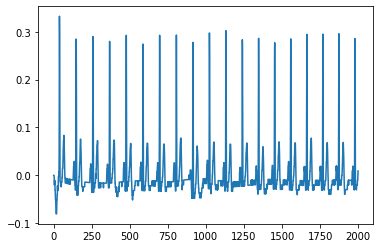

In [41]:
import matplotlib.pyplot as plt

plt.plot(x_input[10][1])

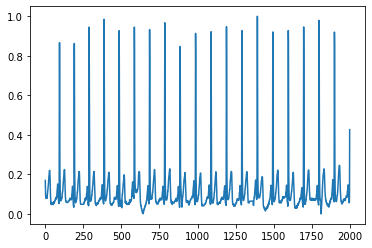

In [44]:
plt.plot(x_train[70,:,1])

In [49]:
ecg_input = x_train[190,:,1]
ecg_input = ecg_input - np.nanmean(ecg_input)
np.mean(ecg_input)

1.0251999e-08

In [57]:
np.mean(x_val[1020,:,1])

1.192093e-10

0.0

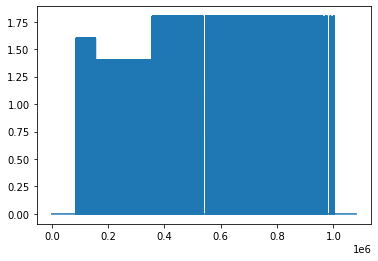

In [13]:
plt.plot(vals[:,2])
np.mean(np.isnan(vals[:,2]))